# Scientific Computing: Assignment Set 1
_Boyan Mihaylov (15067602)_

## 0. Imports / Preliminaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.optimize import minimize_scalar

from importlib import reload

The following code is used to clone the repository in case of using in Google Colab.

In [2]:
# !git clone https://github.com/mboyan/scented-candles
# %ls

# import sys
# sys.path.append('/content/scented-candles/Assignment Set 1')

Cloning into 'scented-candles'...
remote: Enumerating objects: 102, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (88/88), done.
remote: Total 102 (delta 32), reused 56 (delta 12), pack-reused 0
Receiving objects: 100% (102/102), 2.21 MiB | 6.08 MiB/s, done.
Resolving deltas: 100% (32/32), done.
sample_data/  scented-candles/


The code below loads two custom modules: one containing the main functions for solving and analysing the wave equation and the diffusion equation, and another containing utility functions related to the visualisation of results.

In [2]:
import pde_simulations as pde
import vis_tools as vt

## 1. The 1D Wave Equation

The one-dimensional wave equation can be used to represent the vibrations of a uniform string and takes the form:

$$
\frac{\partial^2\Psi}{\partial t^2}=c^2\frac{\partial^2\Psi}{\partial x^2}.\tag{1}
$$

This equation describes the relationship between the second derivative of the vibration amplitude $\Psi$ with respect to time and the second derivative of the amplitude with respect to a position along the string. The multiplicative factor $c$ is a characteristic physical constant describing the material properties. The variable of interest is $\Psi(x, t)$, which represents the amplitude of the string's vibration as defined by the displacement of a position on the string as a function of time.

### 1.1. Discretising the Equation

In order to obtain a numerical solution for $\Psi(x, t)$, the equation needs to be discretised through the means of Finite Differencing. In the case of second-order derivatives, this allows expressing the temporal and the spatial terms as

$$
\frac{\partial^2\Psi}{\partial t^2}\equiv\frac{u_{i,j+1}+u_{i,j-1}-2u_{i,j}}{\delta{t}^2}
$$

and

$$
\frac{\partial^2\Psi}{\partial x^2}\equiv\frac{u_{i+1,j}+u_{i-1,j}-2u_{i,j}}{\delta{x}^2},
$$

respectively, with $u_{i,j}$ being the discrete equivalent of $\Psi(x, t)$ in the spatial ($i\equiv x$) and temporal ($j\equiv t$) domain. Substituting the corresponding terms in (1) yields the following equation:

$$
\frac{u_{i,j+1}+u_{i,j-1}-2u_{i,j}}{\delta{t}^2} = c^2 \left[\frac{u_{i+1,j}+u_{i-1,j}-2u_{i,j}}{\delta{x}^2}\right].
$$

Rewriting it, one can obtain the time-iteration function:

$$
u_{i,j+1}=c^2\delta{t}^2\left[\frac{u_{i+1,j}+u_{i-1,j}-2u_{i,j}}{\delta{x}^2}\right] - u_{i, j-1} + 2u_{i,j}.
$$

Therefore, at any update, the amplitude at the current position is taken into account for the previous timestep, along with the amplitude at the current position and its neighbours for the current timestep.

### 1.2. Boundary and Initial Conditions

The length $L$ of the string is normalised to unity for convenience. A spatial discretisation is performed with $N=1000$ subdivisions, resulting in $\Delta{x}=10^{-3}$. For the numerical experiment it is assumed that the boundaries of the string are fixed, meaning that:

$$
\Psi(x=0,t)=\Psi(x=1,t)=0.
$$

The experiment assumes a constant $c$ is set to $1$ and a timestep $\Delta{t}=0.001$. Three different initial conditions are explored:

1) $\Psi(x,t=0)=sin(2\pi x)$;
2) $\Psi(x,t=0)=sin(5\pi x)$;
3) $\Psi(x,t=0)=sin(5\pi x)$ if $1/5<x<2/5$, else $\Psi=0$.

It is assumed that at time $t=0$ the string is at rest, meaning that the derivative $\Psi'(x,t)$ is zero. This implies that the initial condition also extends to time $t=-1$.

The simulations are run for 100 iterations.

In [3]:
reload(pde)
reload(vt)

<module 'vis_tools' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 1\\vis_tools.py'>

In [3]:
# Simulation parameters
t_max = 1.1
N = 1000
dt = 0.001
n_frames = int(np.floor(t_max / dt))

# Initial conditions
x_samples = np.linspace(0, 1, N)
init_cond = np.empty((4, N))
init_cond[0] = np.sin(2*np.pi*x_samples)
init_cond[1] = np.sin(5*np.pi*x_samples)
init_cond[2] = np.where((x_samples > 0.2) & (x_samples < 0.4), init_cond[1], 0)
init_cond[3] = np.where(x_samples < 0.25, x_samples*4, 1 - (4*x_samples-1)/3)

# Run simulations
u_evolution = np.empty((init_cond.shape[0], n_frames, init_cond.shape[1]))
for i in range(init_cond.shape[0]):
    u_evolution[i] = pde.vibrating_string(init_cond[i], t_max, dt=dt)

### 1.3. Results

Next, the results of the simulations are plotted.

[]

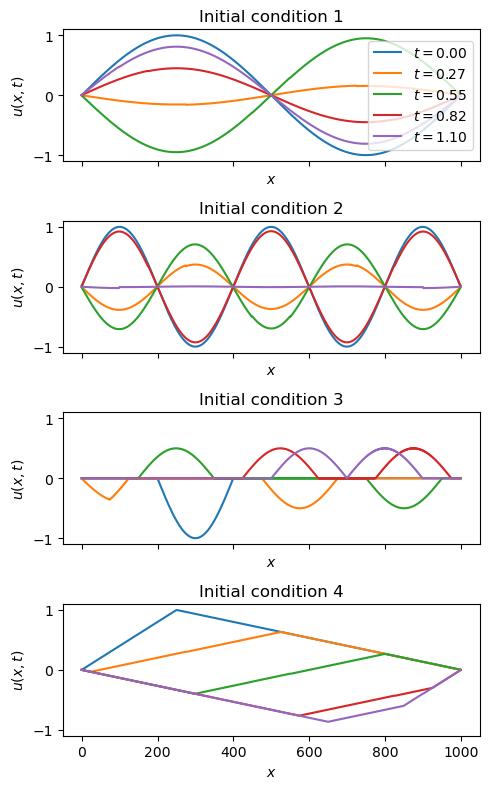

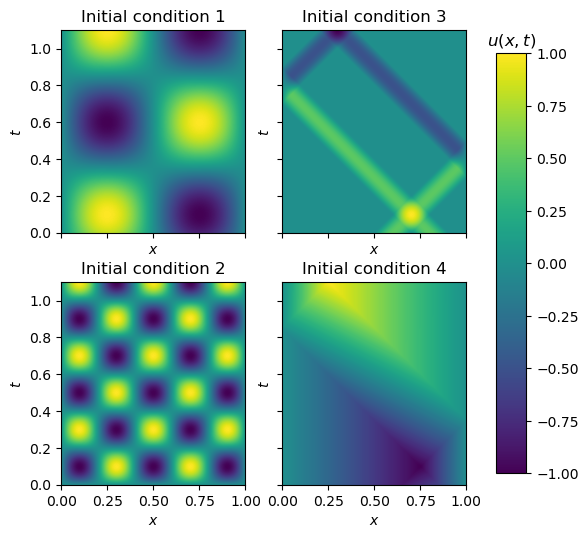

In [ ]:
# Determine moments to plot
n_snapshots = 5
f_plot = np.linspace(0, n_frames-1, n_snapshots, dtype=int)
times = np.arange(0, t_max, dt)

fig, axs = plt.subplots(init_cond.shape[0], 1, sharex=True, sharey=True)
fig.set_size_inches(5, 8)

# Plot amplitudes for different moments in time
for i, u in enumerate(u_evolution):
    for f in f_plot:
        axs[i].plot(u[f], label=f'$t={times[f]:.2f}$')
    axs[i].set_xlabel('$x$')
    axs[i].set_ylabel('$u(x,t)$')
    axs[i].set_title(f'Initial condition {i+1}')
    if i == 0: axs[i].legend()

plt.tight_layout()
plt.plot()

# Plot amplitude evolutions
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(6, 6)
im = []

for i, u in enumerate(u_evolution):
    im.append(axs[i%2, int(np.floor(i/2))].imshow(u, extent=(0, 1, 0, t_max)))
    axs[i%2, int(np.floor(i/2))].set_xlabel('$x$')
    axs[i%2, int(np.floor(i/2))].set_ylabel('$t$')
    axs[i%2, int(np.floor(i/2))].set_title(f'Initial condition {i+1}')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.135, 0.05, 0.7])
cbar_ax.set_title('$u(x,t)$')
fig.colorbar(im[0], cax=cbar_ax)

# plt.tight_layout()
plt.plot()

The following animations illustrate the amplitude changes caused by each initial condition.

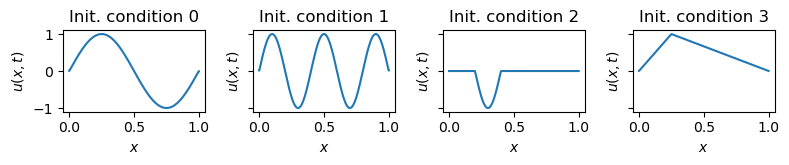

In [ ]:
vt.animate_strings(u_evolution, times, interval=5)

## 2. The Time-Dependent Diffusion Equation

The next exercise explores a two-dimensional implementation of the Time-Dependent Diffusion Equation:
$$
\frac{\partial c}{\partial t}=D\nabla^2c.\tag{2}
$$

In this case, $c(x, y, t)$ represents the concentration of a dissipating substance as a function of space and time. The rate of diffusion is determined by the diffusion constant $D$.

### 2.1. Discretisation

To implement this in a numerical simulation, a finite differencing scheme is used by discretising the spatial domain in $N$ intervals of size $\delta{x}=\delta{y}=1/N$, and the time domain into small intervals of size $\delta{t}$. The zero-based indices $i, j, k$ iterate over the discretized $x$, $y$ and $t$, respectively, with $i, j \in [0, 1,...,N]$ and $k\in\mathbb{N}$, such that $x=i\delta{x}$, $y=j\delta{x}$ and $t=k\delta{t}$. This way the discretised concentration can be expressed in lattice notation as $c_{i,j}^k$ and the equation terms can be broken down in the following manner:

$$
\frac{\partial c}{\partial t}=\frac{c_{i,j}^{k+1}-c_{i,j}^{k}}{\delta{t}},\tag{3}
$$

$$
\nabla^2c = \frac{\partial^2 c}{\partial x^2} + \frac{\partial^2 c}{\partial y^2},\tag{4}
$$

$$
\frac{\partial^2 c}{\partial x^2} = \frac{c_{i+1,j}^{k}+c_{i-1,j}^{k}-2c_{i,j}^{k}}{\delta{x^2}},\tag{5}
$$

$$
\frac{\partial^2 c}{\partial y^2} = \frac{c_{i,j+1}^{k}+c_{i,j-1}^{k}-2c_{i,j}^{k}}{\delta{x^2}}.\tag{6}
$$

Equations (3)-(6) can be substituted into (2) to produce the following relation:

$$
\frac{c_{i,j}^{k+1}-c_{i,j}^{k}}{\delta{t}} = D\left[\frac{c_{i+1,j}^{k}+c_{i-1,j}^{k}+c_{i,j+1}^{k}+c_{i,j-1}^{k}-4c_{i,j}^{k}}{\delta{x^2}}\right],\tag{7}
$$

and thus the update scheme can be formulated:

$$
c_{i,j}^{k+1} = \frac{D\delta{t}}{\delta{x^2}}(c_{i+1,j}^{k}+c_{i-1,j}^{k}+c_{i,j+1}^{k}+c_{i,j-1}^{k}-4c_{i,j}^{k}) + c_{i,j}^{k}.\tag{8}
$$

The simulation is performed on a square lattice with a cylindrical topology, i.e. periodically connected along the x-axis. The top and the bottom of the lattice are defined as a constant source (Heaviside function) and a constant sink, respectively. This imposes analogous boundary conditions for both the continuous and discrete scheme:

$$
c(x,y=1,t)=c_{i,N}^{k}=1; \quad c(x,y=0,t)=c_{i,0}^{k}=0.
$$

At initialisation time, the concentration at each site of the lattice apart from the source row is set to zero:

$$
c(x,y,t=0)=0 \quad \textrm{for} \quad 0\le x \le 1, \quad 0\le y <1.
$$

For the side boundaries (left and right) the special condition is:

$$
c_{i,j}^{k+1} = \frac{D\delta{t}}{\delta{x^2}}(c_{p,j}^{k}+c_{q,j}^{k}+c_{i,j+1}^{k}+c_{i,j-1}^{k}-4c_{i,j}^{k}) + c_{i,j}^{k} \quad \textrm{for} \quad i=0, \quad i=N, \quad \textrm{where} \quad p=(i+1)\bmod{N}, \quad q=(i-1)\bmod{N}.
$$

The cylindrical wrapping of the grid topology is illustrated in the figure below, along with the source row highlighted in yellow.

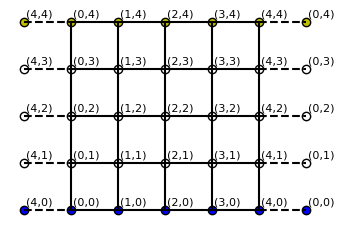

In [47]:
vt.plot_lattice_map(5)

### 2.2. Implementation

These conditions are implemented in a numerical solver which allows two modes of operation - one making use of vectorised transformations of _NumPy_ arrays, the other one parallelising the iterations on the GPU architecture.

For the stability of the solution, it is required that

$$
\frac{4\delta{t}D}{\delta{x}^2}\le1.
$$

With the lattice size $N$ chosen as an input parameter, $\delta{x}=1/N$ and thus:

$$
\delta{t}\le\frac{1}{4DN^2}.
$$

With $D=1$ and a slight safety margin, the timestep $\delta{t}$ is therefore calculated as $\frac{1}{8N^2}$.

In [130]:
# Simulation parameters
t_max = 1.0
N = 100

# Determine dt based on stability requirement
dt = 1 / (8 * N ** 2)
print('dt =', dt)

# Initial condition
c_init = np.zeros((N, N))

c_evolution, times = pde.diffusion_system_time_dependent(c_init, t_max, dt=dt, n_save_frames=1000, run_GPU=False)

dt = 1.25e-05
Simulation running for 80001 steps.


Both modes of execution result in the same outcome, with the GPU-accelerated method yielding significant improvement in performance for large simulation times and lattice sizes.

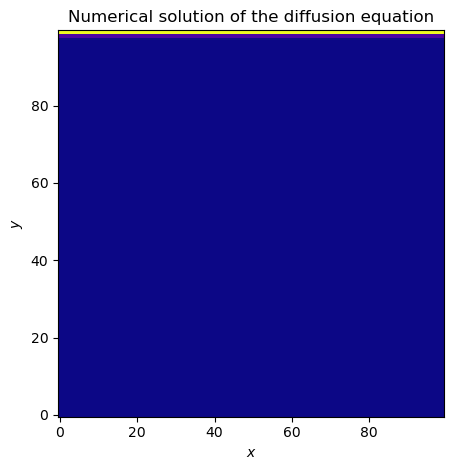

In [6]:
vt.animate_diffusion(c_evolution, times, interval=10)

The outcome of the simulation can be verified by comparison with the analytical solution following the formula:

$$
c(y,t)=\sum_{i=0}^{\infty}\mathrm{erfc}\left(\frac{1-y+2i}{2\sqrt{Dt}}\right)-\mathrm{erfc}\left(\frac{1+y+2i}{2\sqrt{Dt}}\right).
$$

In its finite implementation, this sum is allowed to converge for $10^6$ steps of $i$.

The following plots compare the two solutions along a vertical slice of the lattice for several simulation times.

d:\Msc Computational Science\S02P01\Scientific Computing\GitHub\scented-candles\Assignment Set 1\pde_simulations.py:251: RuntimeWarning: divide by zero encountered in divide
  def verify_analytical_tdde(c_frame, t, D=1.0, precision_steps=1e6):


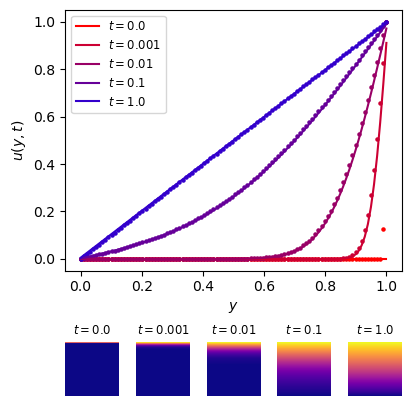

In [19]:
# Select subset of frames
times_select = [0.0, 0.001, 0.01, 0.1, 1.0]
i_select = np.array([i for i in range(len(times)) if times[i] in times_select], dtype=int)
c_evol_select = c_evolution[i_select]

analytical_solution = np.empty_like(c_evolution)
error = np.empty_like(c_evolution)

# Determine continuous and discrete sample range
y_range = np.linspace(0, 1, N)

# fig, ax = plt.subplots(2, 1)
fig, axs = plt.subplot_mosaic([['A', 'A', 'A', 'A', 'A'], ['B', 'C', 'D', 'E', 'F']], layout='constrained', height_ratios=[0.8, 0.2])
fig.set_size_inches(4, 4)

for i, i_s in enumerate(i_select):
    analytical_solution[i], error[i] = pde.verify_analytical_tdde(c_evol_select[i], times[i_s])

    col = (1 - i / len(i_select), 0, i / len(i_select))

    axs['A'].plot(y_range, analytical_solution[i, 0, :], label=f'$t={times[i_s]}$', color=col)
    axs['A'].scatter(y_range, c_evol_select[i, :, 0], color=col, s=5)
    axs['BCDEF'[i]].imshow(c_evol_select[i], vmin=0.0, vmax=1.0, origin='lower', cmap='plasma')
    axs['BCDEF'[i]].set_axis_off()
    axs['BCDEF'[i]].set_title(f'$t={times[i_s]}$', fontsize='small')

axs['A'].set_xlabel('$y$')
axs['A'].set_ylabel('$u(y,t)$')
axs['A'].legend(fontsize='small')

plt.show()

### 2.3. Performance Optimisation

The efficiency of the model can be improved significantly by implementing three modifications of the iteration scheme.

First, assuming that the model is meant to represent a steady-state configuration of the system, the term $\nabla^2c$ can be set to zero and the time variable can be neglected by setting $\delta{t}D/\delta{x}^2=1/4$, yielding the **Laplace equation**:

$$
c_{i,j}=\frac{1}{4}(c_{i+1,j}+c_{i-1,j}+c_{i,j+1}+c_{i,j-1}).
$$

The finite difference scheme for this equation is the **Jacobi iteration**:

$$
c_{i,j}^{(n+1)}=\frac{1}{4}\left(c_{i+1,j}^{(n)}+c_{i-1,j}^{(n)}+c_{i,j+1}^{(n)}+c_{i,j-1}^{(n)}\right).
$$

To ensure convergence of this scheme, a stopping criterion must be implemented which terminates the loop whenever the maximum change in concentration $\delta$ is below a threshold value $\epsilon$ (by default, $\epsilon=10^{-5}$). As with the time-dependent diffusion equation, a parallelised version of the algorithm is also provided.

The Jacobi iteration scheme requires the storage of two lattice arrays, of which one always serves as an input array for the other. This can be further optimised by implementing a **Gauss-Seidel iteration**, which modifies the array in place and thus requires only one instance of it. The update scheme is expressed as follows:

$$
c_{i,j}^{(n+1)}=\frac{1}{4}\left(c_{i+1,j}^{(n)}+c_{i-1,j}^{(n+1)}+c_{i,j+1}^{(n)}+c_{i,j-1}^{(n+1)}\right).
$$

Finally, the convergence toward the steady-state equilibrium can be accelerated by implementing **Successive Over-Relaxation (SOR)** involving a relaxation factor $\omega$:

$$
c_{i,j}^{(n+1)}=\frac{\omega}{4}\left(c_{i+1,j}^{(n)}+c_{i-1,j}^{(n+1)}+c_{i,j+1}^{(n)}+c_{i,j-1}^{(n+1)}\right) + (1-\omega)c_{i,j}^{(n)}.
$$

All these schemes are compared in their convergence to the analytical solution $ \lim_{x\to\infty} c(y) = y$ on a lattice of size $N=50$. For the SOR scheme an $\omega$ value of 1.85 is chosen, which should guarantee a safe tradeoff between convergence and numerical stability.

In [3]:
# Initial condition
N = 50
c_init = np.zeros((N, N))

c_evolution_jacobi, _ = pde.diffusion_system_time_independent(c_init, save_interval=1)
c_evolution_gs, _ = pde.diffusion_system_time_independent(c_init, gauss_seidel=True, save_interval=1)
c_evolution_sor, _ = pde.diffusion_system_time_independent(c_init, gauss_seidel=True, omega=1.85, save_interval=1)

c_evolution_all = [c_evolution_jacobi, c_evolution_gs, c_evolution_sor]

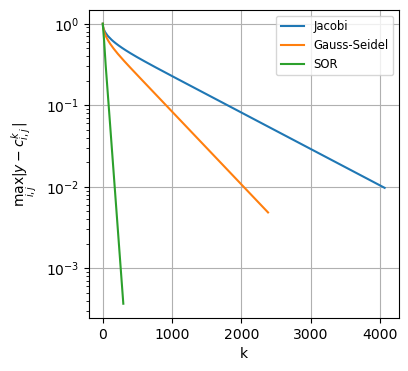

In [26]:
vt.plot_error_convergence(c_evolution_all, labels=['Jacobi', 'Gauss-Seidel', 'SOR'])

The iteration difference $\delta$ is also a significant indicator for the convergence of each algorithm to a solution. It is therefore examined in a similar plot, this time taking several values of $\omega$ into account for the SOR scheme: $\omega = 1.1, 1.3, 1.5, 1.7, 1.9$. The case of $\omega=1$ is considered to be equivalent to the Gauss-Seidel method.

In [13]:
c_evolution_all = [c_evolution_jacobi, c_evolution_gs]
strategy_labels = ['Jacobi', 'Gauss-Seidel']

omegas = np.linspace(1.1, 1.9, 5)
for omega in omegas:
    c_evolution_all.append(pde.diffusion_system_time_independent(c_init, gauss_seidel=True, omega=omega, save_interval=1)[0])
    strategy_labels.append(f'SOR, $\omega={omega}$')

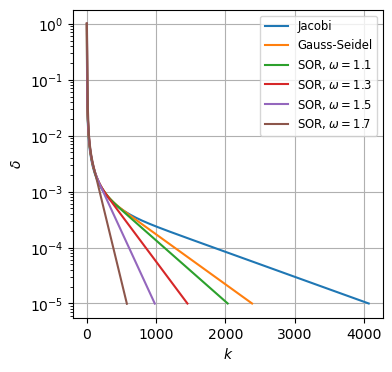

In [12]:
vt.plot_delta_convergence(c_evolution_all, labels=strategy_labels)

In view of the high performance of the SOR method, the question arises how the optimal relaxation parameter $\omega$ can be found. A first inquiry into this can be done by plotting the number of iterations until convergence against different values of $\omega$ in the domain beween 1 and 2. It is thereby relevant to observe how the lattice size $N$ affects the outcome. To speed up the exploration of a dense range of parameter values, the iteration functions are adapted for GPU paralellisation using _numba_'s CUDA interface. The kernel used in the parallelisation is always $16\times 16$. For the Gauss-Seidel and SOR methods a Red-Black checkerboard scheme is implemented by separating the lattice array into two interlaced semi-lattices of equal size. This imposes the constraint that the lattice sizes are always even integers. The explored values of $N$ are powers of 2, starting from $N=32$. To reduce the communication operations, the convergence check is performed at a specified interval of iterations, in this case every 10 iterations.

In [8]:
# Simulation parameters
omega_range = np.linspace(1, 2, 21)
N_range = 2 ** np.arange(5, 9)

# DataFrame for storing simulation results
df_k_termination = pd.DataFrame(columns=['$\omega$', '$N$', '$k$'])

for omega in omega_range:
    for N in N_range:
        c_init = np.zeros((N, N))
        
        _, k_final = pde.diffusion_system_time_independent(c_init, n_max_iter=int(3e4), gauss_seidel=True, omega=omega, save_interval=100, run_GPU=True)
        df_k_termination = pd.concat([df_k_termination, pd.DataFrame([{'$\omega$': omega, '$N$': N, '$k$':k_final}])])

c:\Users\mihbo\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:538: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Terminating after 1200 iterations.


c:\Users\mihbo\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:538: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Terminating after 3600 iterations.


c:\Users\mihbo\anaconda3\Lib\site-packages\numba\cuda\dispatcher.py:538: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Terminating after 9800 iterations.
Terminating after 20800 iterations.
Terminating after 1100 iterations.
Terminating after 3300 iterations.
Terminating after 9100 iterations.
Terminating after 20000 iterations.
Terminating after 1000 iterations.
Terminating after 3100 iterations.
Terminating after 8500 iterations.
Terminating after 19200 iterations.
Terminating after 900 iterations.
Terminating after 2800 iterations.
Terminating after 8000 iterations.
Terminating after 18300 iterations.
Terminating after 900 iterations.
Terminating after 2600 iterations.
Terminating after 7400 iterations.
Terminating after 17400 iterations.
Terminating after 800 iterations.
Terminating after 2400 iterations.
Terminating after 6900 iterations.
Terminating after 16500 iterations.
Terminating after 700 iterations.
Terminating after 2200 iterations.
Terminating after 6400 iterations.
Terminating after 15600 iterations.
Terminating after 700 iterations.
Terminating after 2000 iterations.
Terminating after 

For a more fine-grain search of the parameter value, a numerical optimisation such as the bounded Brent method implemented in `scipi.optimize.minimize_scalar` can be used. For this, a single lattice size, $N=128$, is observed.

To provide an appropriate input for the `scipy.optimize` method, the simulation execution is performed within a utility function which fixes the required parameters, takes `omega` as a first argument and returns the number of iterations until convergence.

In [20]:
def run_diff_sim_omega(omega, N=128):
    """
    Run diffusion simulation with given omega and lattice size.
    """
    c_init = np.zeros((N, N))
    return pde.diffusion_system_time_independent(c_init, n_max_iter=int(3e4), gauss_seidel=True, omega=omega, save_interval=1000, run_GPU=False)[1]

res = minimize_scalar(run_diff_sim_omega, 1.9, args=(128), bounds=(1.8, 1.999))
omega_opt = res.x
k_min = res.fun
print(f"Optimal omega: {omega_opt:.3f}, k_min: {k_min}")

Terminating after 1254 iterations.
Terminating after 829 iterations.
Terminating after 544 iterations.
Terminating after 391 iterations.
Terminating after 650 iterations.
Terminating after 407 iterations.
Terminating after 399 iterations.
Terminating after 388 iterations.
Terminating after 387 iterations.
Terminating after 387 iterations.
Terminating after 390 iterations.
Terminating after 387 iterations.
Terminating after 387 iterations.
Terminating after 387 iterations.
Terminating after 387 iterations.
Terminating after 387 iterations.
Terminating after 387 iterations.
Terminating after 387 iterations.
Terminating after 387 iterations.
Terminating after 387 iterations.
Optimal omega: 1.969, k_min: 387


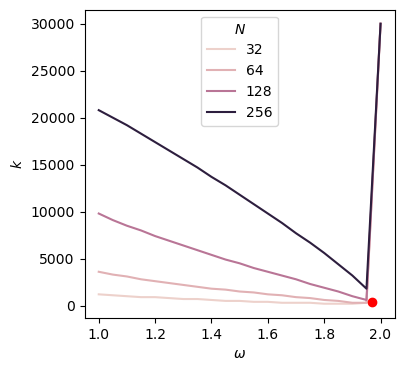

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(4, 4)

sns.lineplot(df_k_termination, x='$\omega$', y='$k$', hue='$N$', ax=ax)
ax.plot(omega_opt, k_min, 'ro')

plt.show()

### 2.4. Lattice Objects

Having tested and calibrated the SOR algorithm in the simplified domain, the system can now be enhanced by incorporating spatial regions with a specific behaviour (sinks, sources, isolators). This can be done by initialising a copy of the lattice with specific sites set to a value describing their behaviour. For sites with assigned zeros, the regions have the effect of sinks, while positive values yield source behaviour. For regions which do not affect the diffusion, an `numpy.nan` value is supplied.

The object initialisation function can be called multiple times and allows the definitions of two types of regions: squares and circles. The object lattice can then be additionally supplied to all non-time-dependent diffusion simulations and affects the process by overwriting the new lattice values at each iteration.

The following scenarios are analysed in the next experiment:
- A square-shaped object in the center of the lattice (testing diffusion around sharp objects);
- A circular object in the center of the lattice (testing diffusion around smooth objects);
- A composite figure of intersecting square and circle (testing behaviour at complex concavities);
- A sierpinski carpet (testing diffusion through fractal objects).

In [117]:
reload(pde)

<module 'pde_simulations' from 'd:\\Msc Computational Science\\S02P01\\Scientific Computing\\GitHub\\scented-candles\\Assignment Set 1\\pde_simulations.py'>

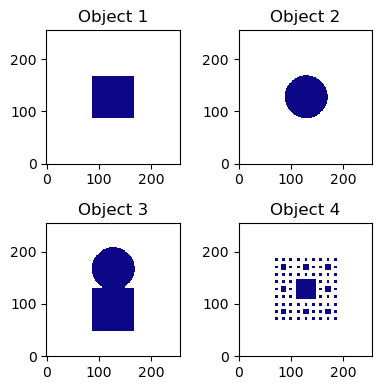

In [171]:
# Initial condition
N = 256
c_init = np.zeros((N, N))

# Initialise objects
center = np.array([N//2, N//2])
c_object_collection = np.empty((4, N, N))

# Square
c_object_collection[0] = pde.init_lattice_object(c_init, center, N / 6, type='square')
# Circle
c_object_collection[1] = pde.init_lattice_object(c_init, center, N / 6, type='circle') 
# Composite
composite = pde.init_lattice_object(c_init, center + np.array([0.15 * N, 0]), N / 6, type='circle')
c_object_collection[2] = pde.init_lattice_object(c_init, center - np.array([0.15 * N, 0]), N / 6, type='square')
c_object_collection[2] = np.where(np.isnan(c_object_collection[2]), composite, c_object_collection[2])
# Sierpinski carpet
c_object_collection[3] = pde.init_lattice_object(c_init, center, N / 2, type='sierpinski carpet')

# Plot objects
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(4, 4)
for i, c_object in enumerate(c_object_collection):
    axs[i//2, i%2].imshow(c_object, origin='lower', cmap='plasma')
    axs[i//2, i%2].set_title(f'Object {i+1}')
plt.tight_layout()
plt.show()

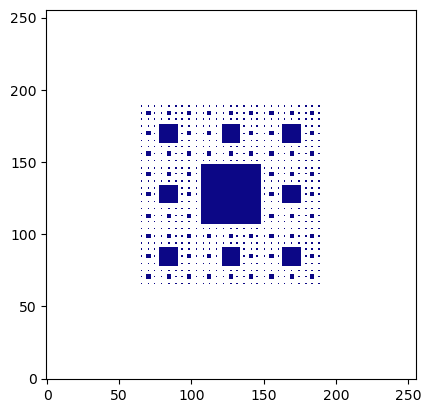

In [116]:
# Preview object
plt.imshow(c_object_collection[3], origin='lower', cmap='plasma')

These modifications of the domain make the comparison with analytical solutions non-trivial, but the convergence to a steady-state can still be analysed, along with the optimal $\omega$ value for the different scenarios.

In [173]:
omega_range = np.linspace(1, 2, 21)

# Variables for storing simulation results
df_k_termination_objects = pd.DataFrame(columns=['$\omega$', 'Object', '$k$'])
c_evolutions_objects = []

for i, c_object in enumerate(c_object_collection):
    for omega in omega_range:
        c_evolution, k_final = pde.diffusion_system_time_independent(c_init, n_max_iter=int(3e4), gauss_seidel=True, omega=omega,
                                                                     save_interval=100, run_GPU=True, objects=c_object)
        df_k_termination_objects = pd.concat([df_k_termination_objects, pd.DataFrame([{'$\omega$': omega, 'Object': i+1, '$k$':k_final}])])
        if omega == 1.9:
            c_evolutions_objects.append(c_evolution)

Terminating after 9000 iterations.
Terminating after 8500 iterations.
Terminating after 7900 iterations.
Terminating after 7400 iterations.
Terminating after 6900 iterations.
Terminating after 6400 iterations.
Terminating after 6000 iterations.
Terminating after 5500 iterations.
Terminating after 5100 iterations.
Terminating after 4600 iterations.
Terminating after 4200 iterations.
Terminating after 3800 iterations.
Terminating after 3400 iterations.
Terminating after 3000 iterations.
Terminating after 2600 iterations.
Terminating after 2200 iterations.
Terminating after 1900 iterations.
Terminating after 1400 iterations.
Terminating after 1000 iterations.
Terminating after 600 iterations.
Terminating after 9800 iterations.
Terminating after 9200 iterations.
Terminating after 8600 iterations.
Terminating after 8100 iterations.
Terminating after 7500 iterations.
Terminating after 7000 iterations.
Terminating after 6500 iterations.
Terminating after 6000 iterations.
Terminating after 560

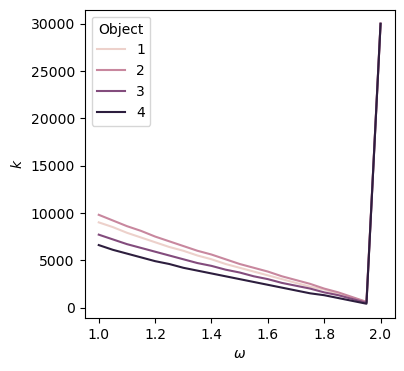

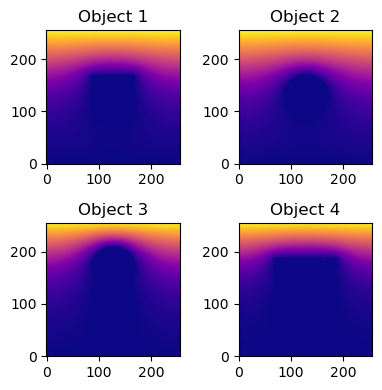

In [174]:
# Plot omega vs k for different objects
fig, ax = plt.subplots()
fig.set_size_inches(4, 4)

sns.lineplot(df_k_termination_objects, x='$\omega$', y='$k$', hue='Object', ax=ax)
plt.show()

# Plot final concentration for different objects
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(4, 4)
for i, c_evol in enumerate(c_evolutions_objects):
    axs[i//2, i%2].imshow(c_evol[-1], origin='lower', cmap='plasma')
    axs[i//2, i%2].set_title(f'Object {i+1}')
plt.tight_layout()
plt.show()

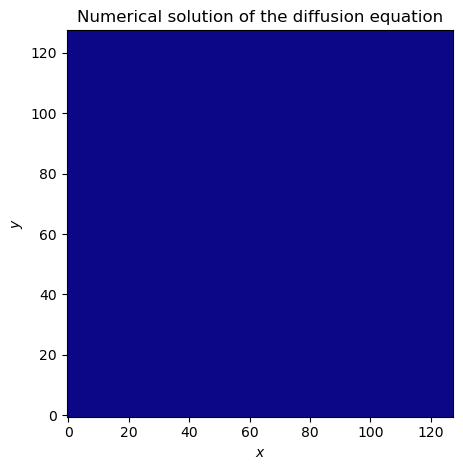

In [95]:
# Animate diffusion with objects
vt.animate_diffusion(c_evolution, np.arange(c_evolution.shape[0]), interval=10)

### 2.5. Insulating Material Objects

Now that the possibility to add sources and sinks with custom geometries to the simulation, the question remains how a non-interacting object, i.e. consisting of an insulating material, can be added to the domain. To analyse the notion of inhibited interactivity, one may return to the fundamental diffusion equation (2) and observe its constituent parts.

The right-hand side is derived from Fick's law and consists of equation (3) multiplied by the diffusion constant $D$. In its essence, the term represents the flux of molecules along each spatial dimension. Equations (5) and (6) can be seen as combinations of two first-order partial derivatives representing the influx and outflux at a spatial location - equivalent to the transmission of concentration between a lattice site and its two neighbours along one dimension. The expanded equation (7) would therefore become the following:

$$
\frac{c_{i,j}^{k+1}-c_{i,j}^{k}}{\delta{t}} = D\left[\frac{c_{i+1,j}^k-c_{i,j}^k}{\delta{x^2}} - \frac{c_{i,j}^k-c_{i-1,j}^k}{\delta{x^2}}\right] + D\left[\frac{c_{i,j+1}^k-c_{i,j}^k}{\delta{x^2}} - \frac{c_{i,j}^k-c_{i,j-1}^k}{\delta{x^2}}\right]
$$

$$
\frac{c_{i,j}^{k+1}-c_{i,j}^{k}}{\delta{t}} = D\left[\frac{c_{i+1,j}^k-c_{i,j}^k}{\delta{x^2}}\right] - D\left[\frac{c_{i,j}^k-c_{i-1,j}^k}{\delta{x^2}}\right] + D\left[\frac{c_{i,j+1}^k-c_{i,j}^k}{\delta{x^2}}\right] - D\left[\frac{c_{i,j}^k-c_{i,j-1}^k}{\delta{x^2}}\right]
$$

It could therefore be argued that if one of these neighbours is a perfectly insulating, non-interacting material, the flux to and from this site would be zero. This can be modelled by assigning different diffusion constants to each neighbour interaction and zeroing the ones which should inhibit the exchange of concentration:

$$
\frac{c_{i,j}^{k+1}-c_{i,j}^{k}}{\delta{t}} = D_1\left[\frac{c_{i+1,j}^k-c_{i,j}^k}{\delta{x^2}}\right] - D_2\left[\frac{c_{i,j}^k-c_{i-1,j}^k}{\delta{x^2}}\right] + D_3\left[\frac{c_{i,j+1}^k-c_{i,j}^k}{\delta{x^2}}\right] - D_4\left[\frac{c_{i,j}^k-c_{i,j-1}^k}{\delta{x^2}}\right]
$$

$$
D_i = \begin{cases}
1, & \textrm{if interacting}.\\
0, & \textrm{if insulating}.
\end{cases}
$$

Rewriting the equation in the form of (8) yields:

$$
c_{i,j}^{k+1} = \frac{D_1\delta{t}}{\delta{x^2}}(c_{i+1,j}^k-c_{i,j}^k) + \frac{D_2\delta{t}}{\delta{x^2}}(c_{i-1,j}^k-c_{i,j}^k) + \frac{D_3\delta{t}}{\delta{x^2}}(c_{i,j+1}^k-c_{i,j}^k) + \frac{D_4\delta{t}}{\delta{x^2}}(c_{i,j-1}^k+c_{i,j}^k)+c_{i,j}^{k},
$$

$$
c_{i,j}^{k+1} = \frac{\delta{t}}{\delta{x^2}}\left[D_1(c_{i+1,j}^k-c_{i,j}^k) + D_2(c_{i-1,j}^k-c_{i,j}^k) + D_3(c_{i,j+1}^k-c_{i,j}^k) + D_4(c_{i,j-1}^k+c_{i,j}^k)\right]+c_{i,j}^{k}.
$$


In the steady-state scenario where $\nabla^2c=0$, we can derive an alternative Laplacian scheme and with it a newly formulated Jacobi iteration:

$$
D_1(c_{i+1,j}-c_{i,j}) - D_2(c_{i,j}-c_{i-1,j}) + D_3(c_{i,j+1}-c_{i,j}) - D_4(c_{i,j}-c_{i,j-1}) = 0,
$$

$$
c_{i,j}^{(n+1)}=\frac{D_1c_{i+1,j}^{(n)}+D_2c_{i-1,j}^{(n)}+D_3c_{i,j+1}^{(n)}+D_4c_{i,j-1}^{(n)}}{D_1+D_2+D_3+D_4}.
$$

Following this scheme, all iteration functions can be adapted to incorporate an additional lattice of diffusion parameters, from which the corresponding neighbour $D_i$ values can be obtained. The initialisation of isolator objects can be conducted in the same way as with the sink/source objects, using the same geometric primitives. For this experiment, the new feature is only tested on the time-dependent evolution on a lattice of size $N=128$ with the purpose of observing potential temporal effects.

In [176]:
# Initial condition
N = 256
c_init = np.zeros((N, N))

# Initialise objects
center = np.array([N//2, N//2])
isolator_collection = np.empty((4, N, N))

# Square
isolator_collection[0] = pde.init_lattice_d_params(c_init, center, N / 6, type='square')
# Circle
isolator_collection[1] = pde.init_lattice_d_params(c_init, center, N / 6, type='circle') 
# Composite
isolator_collection[2] = pde.init_lattice_d_params(c_init, center - np.array([0.15 * N, 0]), N / 6, type='square') * pde.init_lattice_d_params(c_init, center + np.array([0.15 * N, 0]), N / 6, type='circle')
# Sierpinski carpet
isolator_collection[3] = pde.init_lattice_d_params(c_init, center, N / 2, type='sierpinski carpet')

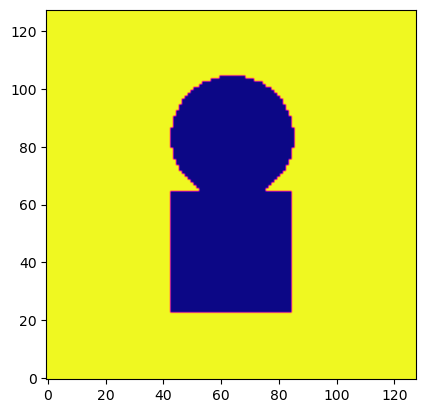

In [164]:
plt.imshow(isolator_collection[2], origin='lower', cmap='plasma')

In [177]:
# Simulation parameters
t_max = 1.0

# Determine dt based on stability requirement
dt = 1 / (8 * N ** 2)
print('dt =', dt)

# Initial condition
c_init = np.zeros((N, N))

c_evolutions = []
for isolator in isolator_collection:
    c_evolution, times = pde.diffusion_system_time_dependent(c_init, t_max, dt=dt, n_save_frames=1000, run_GPU=True, isolators=isolator)
    c_evolutions.append(c_evolution)

dt = 7.62939453125e-06
Simulation running for 131073 steps.
Simulation running for 131073 steps.
Simulation running for 131073 steps.
Simulation running for 131073 steps.


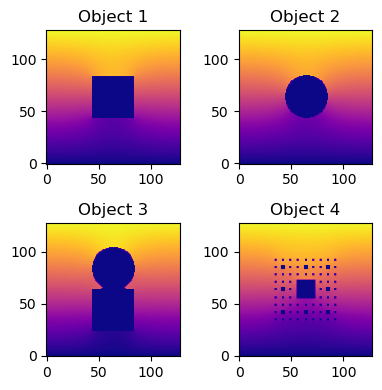

In [178]:
# Plot final concentration for different isolators
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(4, 4)
for i, c_evol in enumerate(c_evolutions):
    axs[i//2, i%2].imshow(c_evol[-1], origin='lower', cmap='flag')
    axs[i//2, i%2].set_title(f'Object {i+1}')
plt.tight_layout()
plt.show()

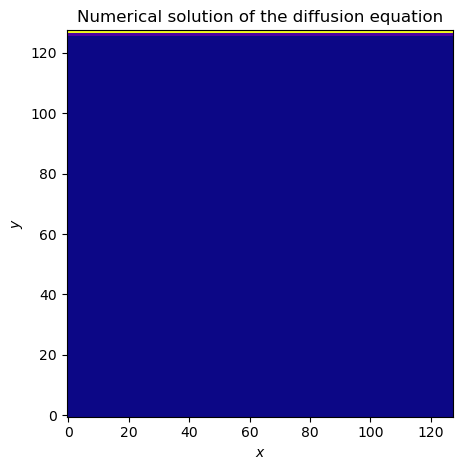

In [170]:
vt.animate_diffusion(c_evolutions[-1], times, interval=10)